# PyTorch for Fast and Easy Machine Learning

https://github.com/compdyn/pytorch_tutorial

**Matthew West**  
mwest@illinois.edu  
http://lagrange.mechse.illinois.edu/  
https://github.com/mwest1066

_"Hands-On with CSE" tutorial series_

April 26, 2019

**Description:** PyTorch allows you to easily train and run machine learning models. It uses standard Python methods for writing code, so it's both simple and powerful. We will cover the core automatic differentiation capabilities of PyTorch, training deep neural networks, using GPUs and parallel computation, managing training and test data, saving and loading models, and visualizing training progress. We will assume a good knowledge of Python and NumPy, and basic knowledge of machine learning with neural nets.

# List of resources

- PyTorch tutorials: https://pytorch.org/tutorials/
- PyTorch manual: https://pytorch.org/docs/stable/index.html
- PyTorch paper: https://openreview.net/forum?id=BJJsrmfCZ
- Calculus on computational graphs: http://colah.github.io/posts/2015-08-Backprop/
- Einstein summation in PyTorch: https://rockt.github.io/2018/04/30/einsum

# PyTorch citation

```
@inproceedings{paszke2017automatic,
  title={Automatic differentiation in PyTorch},
  author={Paszke, Adam and Gross, Sam and Chintala, Soumith and Chanan, Gregory and Yang, Edward and DeVito, Zachary and Lin, Zeming and Desmaison, Alban and Antiga, Luca and Lerer, Adam},
  booktitle={NIPS-W},
  year={2017},
  url={https://openreview.net/forum?id=BJJsrmfCZ},
}
```

# What is PyTorch?

- Like NumPy with automatic differentiation via dynamic computation graphs
- Transparent ability to compute on GPUs and in parallel
- Library of neural net functions and constructors
- Library of gradient-based optimizers
- Various other useful functions (e.g., data management)

# Installing PyTorch

- Use Anaconda
- https://pytorch.org/get-started/locally/
- At the moment we need Python 3.6 to support TensorBoard
```
conda create --name torch python=3.6
conda activate torch
conda install scipy matplotlib jupyter
conda install pytorch torchvision -c pytorch
pip install tensorflow # for TensorBoard
pip install tensorboardX # bridge from PyTorch
jupyter-notebook
```

# Let's get started!

In [310]:
import torch
import numpy as np
import random, datetime
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch is similar to NumPy

PyTorch works in immediate mode, which is different to the default TensorFlow model.

PyTorch is very picky about datatypes, and defaults to single precision (NumPy defaults to double).

In [326]:
x = torch.tensor([1.0, 2.0, 3.0])

In [327]:
x

tensor([1., 2., 3.])

In [328]:
x**2

tensor([1., 4., 9.])

In [329]:
x.dtype

torch.float32

#### Specify datatypes

Use `dtype=torch.float64` and `.double()`

In [336]:
y = x.double()

In [337]:
y

tensor([1., 2., 3.], dtype=torch.float64)

In [338]:
y.dtype

torch.float64

In [339]:
x = torch.tensor([1, 2, 3])

In [340]:
torch.log(x)

RuntimeError: "log" not implemented for 'torch.LongTensor'

In [341]:
x.dtype

torch.int64

In [342]:
x = torch.tensor([1, 2, 3], dtype=torch.float64)

In [343]:
torch.log(x)

tensor([0.0000, 0.6931, 1.0986], dtype=torch.float64)

#### Annoying differences from NumPy

`np.sum(x, axis=1)` versus `torch.sum(x, dim=1)`

`np.clip()` versus `torch.clamp()`

In [344]:
np.log([1, 2, 3]).clip(0, 1)

array([0.        , 0.69314718, 1.        ])

In [345]:
torch.log(x).clip(0, 1)

AttributeError: 'Tensor' object has no attribute 'clip'

In [346]:
torch.log(x).clamp(0, 1)

tensor([0.0000, 0.6931, 1.0000], dtype=torch.float64)

#### Convert to/from NumPy arrays

`.numpy()` and `torch.from_numpy()`

Memory is shared!

In [347]:
x = np.array([1, 2, 3])
y = torch.from_numpy(x)
y

tensor([1, 2, 3])

In [348]:
x[0] = 7
y

tensor([7, 2, 3])

# `torch.autograd`: Computing derivatives

PyTorch constructs the computation graph as you do operations (dynamic graphs) unlike TensorFlow (static graphs)

Using the computation graph, the chain rule (back propagation) can compute derivatives

Derivatives are available in the leaf nodes

In [118]:
x = torch.tensor(5.0)

In [119]:
y = torch.tensor(3.0, requires_grad=True)

In [120]:
z = x * y**2
z

tensor(45., grad_fn=<MulBackward0>)

In [121]:
z.backward()

In [122]:
print(f'x.grad = {x.grad}')

x.grad = None


In [123]:
y.grad

tensor(30.)

$z = x y^2$

$\frac{\partial z}{\partial y} = 2 x y$

In [124]:
2*x*y

tensor(30., grad_fn=<MulBackward0>)

#### Control what we differentiate with respect to

`requires_grad=True`

`with no_grad():`

`.detach()`

In [129]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = True
dz/dx = 12.0


In [130]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
y = y.detach() # can't say y.requires_grad = False
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


In [131]:
x = torch.tensor(2.0, requires_grad=True)
with torch.no_grad():
    y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


#### Computation graphs are not trees

Re-using a parameter in multiple places makes the graph not be a tree. It's a DAG.

In [284]:
x = torch.tensor(2.0, requires_grad=True)
y = 3*x
z = x**2
w = y + z + x
w.backward()
x.grad

tensor(8.)

$\frac{\partial w}{\partial x} = \frac{\partial}{\partial x}(3x + x^2 + x) = 3 + 2x + 1$

In [285]:
3 + 2*x + 1

tensor(8., grad_fn=<AddBackward0>)

#### The computation graph is destroyed by `backward()`

To retain it for more differentiation, use `backward(retain_graph=True)`

A common use case is multiple outputs with a shared subgraph

Don't forget to free the graph on the last call to prevent memory leaks

In [95]:
x = torch.tensor(3.0, requires_grad=True)
y = x**2
z1 = 3*y
z2 = 4*y

In [96]:
z1.backward() # (retain_graph=True)
x.grad

tensor(18.)

In [97]:
z2.backward()
x.grad

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

#### Derivatives of scalars with respect to tensors

In [313]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = (x**2).sum()
y.backward()
x.grad

tensor([2., 4., 6.])

#### Don't do in-place modifications to tensors

But it's fine to do `x = 4 * x`

In [319]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

In [320]:
x[1] = x[2] + 1

In [321]:
y = (x**2).sum()
y.backward()

RuntimeError: leaf variable has been moved into the graph interior

# Using a GPU

In [98]:
torch.cuda.is_available()

False

#### Create variables on the GPU

In [134]:
x = torch.ones(4, device="cuda")

AssertionError: Torch not compiled with CUDA enabled

#### Transfer variables to/from the GPU

In [135]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
x = x.to('cuda')
y = y.to('cuda')
z = x * y
z = z.to('cpu')
z

AssertionError: Torch not compiled with CUDA enabled

# `torch.optim`: All the common gradient-based optimizers

In [144]:
def f(x):
    return x**2

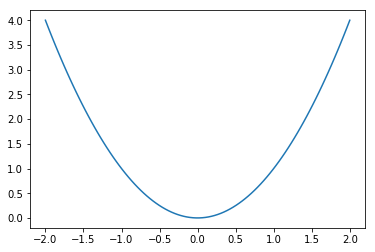

In [147]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec);

In [173]:
x = torch.tensor([2.0], requires_grad=True)

In [174]:
opt = torch.optim.SGD([x], lr=0.1)

In [175]:
x_history = [x.detach().numpy().copy()]
for i in range(10):
    print(f'##########')
    print(f'i = {i}')
    print(f'initial x = {x}')
    opt.zero_grad()
    z = f(x)
    print(f'z = {z}')
    z.backward()
    print(f'x.grad = {x.grad}')
    opt.step()
    print(f'updated x = {x}')
    x_history.append(x.detach().numpy().copy())

##########
i = 0
initial x = tensor([2.], requires_grad=True)
z = tensor([4.], grad_fn=<PowBackward0>)
x.grad = tensor([4.])
updated x = tensor([1.6000], requires_grad=True)
##########
i = 1
initial x = tensor([1.6000], requires_grad=True)
z = tensor([2.5600], grad_fn=<PowBackward0>)
x.grad = tensor([3.2000])
updated x = tensor([1.2800], requires_grad=True)
##########
i = 2
initial x = tensor([1.2800], requires_grad=True)
z = tensor([1.6384], grad_fn=<PowBackward0>)
x.grad = tensor([2.5600])
updated x = tensor([1.0240], requires_grad=True)
##########
i = 3
initial x = tensor([1.0240], requires_grad=True)
z = tensor([1.0486], grad_fn=<PowBackward0>)
x.grad = tensor([2.0480])
updated x = tensor([0.8192], requires_grad=True)
##########
i = 4
initial x = tensor([0.8192], requires_grad=True)
z = tensor([0.6711], grad_fn=<PowBackward0>)
x.grad = tensor([1.6384])
updated x = tensor([0.6554], requires_grad=True)
##########
i = 5
initial x = tensor([0.6554], requires_grad=True)
z = tensor([0.42

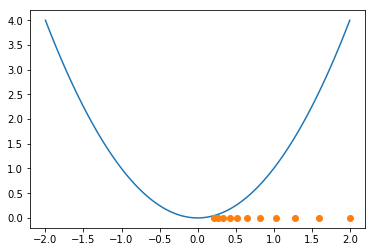

In [176]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec)
plt.plot(x_history, np.zeros(len(x_history)), 'o')

# `torch.nn`: Easy neural-network construction

Convention: the first index is the data-item index, so N images each of shape 128 x 128 will be in a tensor of shape N x 128 x 128

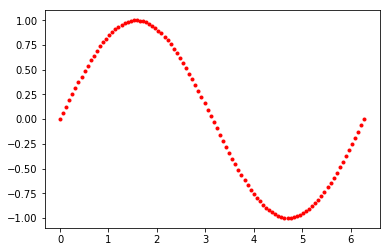

In [289]:
x = torch.linspace(0, 2*np.pi, 100)
y = torch.sin(x)
plt.plot(x.numpy(), y.numpy(), 'r.');

In [290]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(1, 8)
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [291]:
model = MyModel()

In [292]:
yp = model(x.reshape(100,1))

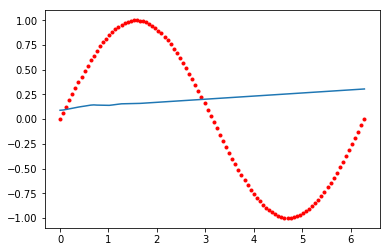

In [293]:
plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), yp.detach().numpy());

In [300]:
model.fc3.weight

Parameter containing:
tensor([[ 0.2287,  0.0777,  0.0376,  0.2521, -0.3096,  0.2225,  0.2876, -0.0827]],
       requires_grad=True)

In [301]:
model.fc3.bias

Parameter containing:
tensor([-0.0882], requires_grad=True)

In [302]:
model.fc3.bias.data

tensor([-0.0882])

In [252]:
for p in model.parameters():
    print(p.shape)

torch.Size([8, 1])
torch.Size([8])
torch.Size([8, 8])
torch.Size([8])
torch.Size([1, 8])
torch.Size([1])


In [253]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_history = []

In [275]:
for i in range(10):
    opt.zero_grad()
    yp = model(x.reshape(100,1))
    loss = torch.nn.MSELoss()(yp, y.reshape(100,1))
    loss_history.append(loss.item())
    loss.backward()
    opt.step()

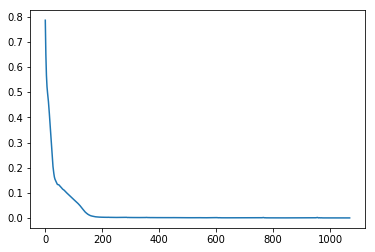

In [276]:
plt.plot(loss_history);

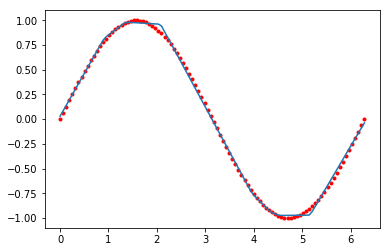

In [277]:
plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), yp.detach().numpy());

# Saving and restoring models

Save and load the parameters, not the full models.

In [279]:
torch.save(model.state_dict(), 'model_file.pkl')

In [280]:
model = MyModel()
model.load_state_dict(torch.load('model_file.pkl'))

In [281]:
model.state_dict()

OrderedDict([('fc1.weight', tensor([[-0.1632],
                      [-0.7957],
                      [ 0.0556],
                      [ 0.9747],
                      [ 0.9280],
                      [-0.4773],
                      [-0.3878],
                      [-0.3842]])),
             ('fc1.bias',
              tensor([ 0.7384, -0.8642,  0.5537,  0.2233, -0.8439, -0.7774, -0.0604,  1.5234])),
             ('fc2.weight',
              tensor([[ 3.5388e-01, -2.1935e-01,  5.4676e-01,  4.4479e-01, -8.8703e-01,
                       -3.0424e-01,  9.6305e-02, -5.9877e-01],
                      [ 3.4691e-01,  1.6012e-01, -2.4304e-01,  1.0643e-01,  1.3228e-01,
                        1.6567e-01,  3.1213e-01,  2.2412e-01],
                      [-7.4438e-01,  9.6188e-02,  7.9792e-01,  3.0626e-01,  3.6360e-01,
                        3.0444e-01,  6.7462e-02, -1.2535e+00],
                      [ 3.0156e-01, -2.8236e-01, -1.9991e-01,  1.0666e+00,  2.0670e-01,
                       -1.7

# Visualizing run-time output with TensorBoard

Run TensorBoard with `tensorboard --logdir training_logs`

Navigate to http://localhost:6006/

In [307]:
import tensorboardX

In [312]:
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
writer = tensorboardX.SummaryWriter(f'training_logs/train-{timestamp}')
for i in range(100):
    loss = np.exp(-i/50)
    writer.add_scalar('loss', loss, i)
    # writer.add_text('parameter value = 65', i)
    
    # plt.ioff()
    # fig = matplotlib.gcf()
    # writer.add_figure('output_visualization', fig, i)
    
    # writer.add_distribution('input_samples', xvec, i)

# `torch.utils.data`: Managing train/test data

In [311]:
import torch.utils.data

In [303]:
x = torch.tensor([0,1,2,3,4,5,6,7,8,9])
y = torch.tensor([10,11,12,13,14,15,16,17,18,19])
d = torch.utils.data.TensorDataset(x, y)

In [304]:
d[0]

(tensor(0), tensor(10))

In [305]:
d[1]

(tensor(1), tensor(11))

In [306]:
(x_sample, y_sample) = d[random.sample(range(len(d)), 4)]
print(f'x_sample = {x_sample}')
print(f'y_sample = {y_sample}')

x_sample = tensor([0, 5, 7, 6])
y_sample = tensor([10, 15, 17, 16])


# Next steps

Choose a tutorial: https://pytorch.org/tutorials/